In [1]:
import os
import subprocess
import firecloud.api as fapi

GEX_Cohort='GEX_CCG1112_LowMt'
REPO = '../..'
WORKFLOW_DATA = f'{REPO}/data/workflow'
EXTERNAL_DATA = f'{REPO}/data/external'
RESULT_DATA = f'{REPO}/data/result/cleaned_files'
Manuscript_RESULT = f'{REPO}/data/result/manuscript_table/'
# load Terra API for get data table from Terra
import sys
import glob
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *
from TerraAPI import get_terra_table_to_df
# load packages and data for the following analysis
import signaturescoring as ssc
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
from statannotations.Annotator import Annotator
import warnings
import commentjson
### Additional Colormap
with open(f'{RESULT_DATA}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

2024-07-03 04:49:16::INFO  pikepdf C++ to Python logger bridge initialized


In [2]:
adata = sc.read(f'{RESULT_DATA}/tumor.h5ad')
print(f"Detect N={adata.shape[0]:,} tumor cells with high quality GEX profiles;")
print(f"max(% of mitocondrial reads): {adata.obs['pct_counts_mito'].max():.0f}")
sample_meta = adata.obs.drop_duplicates(subset=['Sample'])
sample_meta.BestResponse = sample_meta.BestResponse.map({'0-I':'favorable response\n(RCB 0-I)','II-III':'unfavorable response\n(RCB II-III)'})

Detect N=65,206 tumor cells with high quality GEX profiles;
max(% of mitocondrial reads): 5


# Detect the robust recurrent program robustRPH

- Run the workflow https://app.terra.bio/#workspaces/vanallen-firecloud-nih/HR_BrCa_16-466/workflows/jf_scpipe_rna/GEX_CohortSet_DetectRHP
    - Here, we directly use the tumor h5ad as input
- Get the basis and coef pickle files.

In [3]:
import pickle
with open(f'{WORKFLOW_DATA}/{GEX_Cohort}/{GEX_Cohort}/nmf_basis.pickle', "rb") as input_file:
    programs_basis = pickle.load(input_file)

with open(f'{WORKFLOW_DATA}/{GEX_Cohort}/{GEX_Cohort}/nmf_coef.pickle', "rb") as input_file:
    programs_coef = pickle.load(input_file)
    
n_programs = programs_basis[list(programs_basis.keys())[2]].shape[1] * len(programs_basis)
f"Generated {n_programs:,} programs"

'Generated 1,326 programs'

In [4]:
n_top=50
# robustRPH = sp.ext.getRobustRHP(programs=programs_basis,
#                          n_top=n_top,
#                          intra_min = 35, inter_min = 10,intra_max = 10
#                         )
# with open(f'{RESULT_DATA}/robustRPH.pickle', 'wb') as handle:
#     pickle.dump(robustRPH, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{RESULT_DATA}/robustRPH.pickle', "rb") as input_file:
    robustRPH = pickle.load(input_file)
f"Out of {n_programs:,} detected programs, {robustRPH.shape[1]} programs are robust."

'Out of 1,326 detected programs, 195 programs are robust.'

## Get a list of genes in the analysis

In [5]:
bg_genes = pd.Index([])
for k,v in programs_basis.items():
    bg_genes = v.index.union(bg_genes)

## Customized clustering on the RPH

### Look at how the n of samples in various timepoints and conditions


In [6]:
sample_stats = pd.crosstab(index=[sample_meta['Treatment_Arm'],sample_meta['Timepoint']],
            columns=sample_meta['BestResponse'])

sample_stats['total'] =sample_stats.sum(axis=1)
sample_stats

BestResponse             favorable response\n(RCB 0-I)  \
Treatment_Arm Timepoint                                  
Chemo->ICI    AfterSurg                              1   
              Baseline                               1   
              Surg+AC                                0   
              W3D1                                   1   
              W7D1                                   3   
ICI->Chemo    AfterSurg                              0   
              Baseline                               2   
              Surg+AC                                1   
              W3D1                                   0   
              W7D1                                   1   

BestResponse             unfavorable response\n(RCB II-III)  total  
Treatment_Arm Timepoint                                             
Chemo->ICI    AfterSurg                                   2      3  
              Baseline                                    3      4  
              Surg+AC                                     2      2  
              W3D1                                        3      4  
              W7D1                                        1      4  
ICI->Chemo    AfterSurg                                   4      4  
              Baseline                                    6      8  
              Surg+AC                                     1      2  
              W3D1                                        4      4  
              W7D1                                        3      4

### Perform the clustering

as shown above, in timepoints Baseline, W3D1, W7D1, and AfterSurg, we have at least `2` samples per timepoints. Thus, we aimed to find metaprograms that at least shared among three samples and set the `Min_group_size` parameter to be `2`.

In [7]:
import palettable
Cluster_Map,MP_Genesets,Programs_Order,MP_colors = sp.ext.clusterRobustRPH(
    robustRPH=robustRPH,
    programs_basis=programs_basis,
    Min_group_size=2,
    palette=palettable.tableau.Tableau_20.hex_colors + palettable.tableau.TrafficLight_9.hex_colors
)

[Processing]Cluster MP1 has 32 RPH programs.
[Processing]Cluster MP2 has 24 RPH programs.
[Processing]Cluster MP3 has 12 RPH programs.
[Processing]Cluster MP4 has 7 RPH programs.
[Processing]Cluster MP5 has 5 RPH programs.
[Processing]Cluster MP6 has 6 RPH programs.
[Processing]Cluster MP7 has 3 RPH programs.
[Processing]Cluster MP8 has 5 RPH programs.
[Processing]Cluster MP9 has 4 RPH programs.
[Processing]Cluster MP10 has 4 RPH programs.
[Processing]Cluster MP11 has 5 RPH programs.
[Done] Generated 11 MP clusters which covered 55% robust RPH programs.


### Look at MPs related to low data quality 

In [8]:
display(pd.concat([
    MP_Genesets.apply(lambda c:c.str.startswith('MT-').sum(),axis=0).rename('Mitochondrial'),
    MP_Genesets.apply(lambda c:c.str.contains('^RP[LS]').sum(),axis=0).rename('Ribosomal')
],axis=1).sort_values(['Mitochondrial','Ribosomal'],ascending=False))

low_quality_mps = ['MP1']

,Mitochondrial,Ribosomal
MP1,10,33
MP10,2,0
MP2,0,0
MP3,0,0
MP4,0,0
MP5,0,0
MP6,0,0
MP7,0,0
MP8,0,0
MP9,0,0


### Merge sample metadata into the clustering result

In [9]:
anno = Cluster_Map.rename('MetaProgram').to_frame()
anno['Sample'] = anno.index.map(lambda x: x.split('.')[0])
anno = anno.reset_index().merge(sample_meta,on='Sample',how='left').set_index('index')

### explore the patient specific programs

In [10]:
pt_specific = anno.groupby(['MetaProgram'])['Patient'].nunique().sort_values()
pt_specific = pt_specific[pt_specific ==1].index.tolist()

In [11]:
anno['MetaProgram'].value_counts()[pt_specific]

Series([], Name: MetaProgram, dtype: int64)

In [12]:
anno.loc[anno['MetaProgram'].isin(pt_specific),:]

,MetaProgram,Sample,Patient,pct_counts_mito,n_genes_by_counts,Treatment_Arm,BestResponse,Timepoint
index,,,,,,,,


###  Calculate the complexity correaltion

In [13]:
nmf_corr_complexity = []
for k,v in programs_coef.items():
    tmp = v.corrwith(adata.obs.loc[v.index,'n_genes_by_counts'])
    nmf_corr_complexity.append(tmp)
del tmp
nmf_corr_complexity=pd.concat(nmf_corr_complexity,axis=0)
dt = pd.concat([nmf_corr_complexity.abs()>.4,Cluster_Map],axis=1,join='inner').groupby(1)[0].mean()
high_complexity = dt[dt>.5].index.tolist()
high_complexity

['MP10']

In [14]:
dt[dt>.5]

1
MP10    0.75
Name: 0, dtype: float64

### Remove patient specific, high complexity, and unknown program

In [15]:
anno = anno.loc[~anno['MetaProgram'].isin(pt_specific+['MP_Unknown']+low_quality_mps+high_complexity),:]
New_Programs_Order = [ x for x in Programs_Order if x in anno.index]
New_MP_Genesets = MP_Genesets[anno['MetaProgram'].unique().tolist()]
f"Generated {anno['MetaProgram'].nunique()} MP clusters which covered {(anno.shape[0]/robustRPH.shape[1]):.0%} robust RPH programs."

'Generated 9 MP clusters which covered 36% robust RPH programs.'

## Visualize the program similarity 

### Visualize the similarity

In [16]:
def jaccard_index(c1,c2):
    c1 = set(c1)
    c2 = set(c2)
    overlap =  c1.intersection(c2)
    union = c1.union(c2)
    value = len(overlap)/len(union)
    return value

## Jaccard index    
sm = robustRPH.apply(
        lambda c1:
            robustRPH.apply(
            lambda c2: jaccard_index(c1,c2) * 100
            ,axis=0)
        ,axis=0)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 78.67083333333333 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


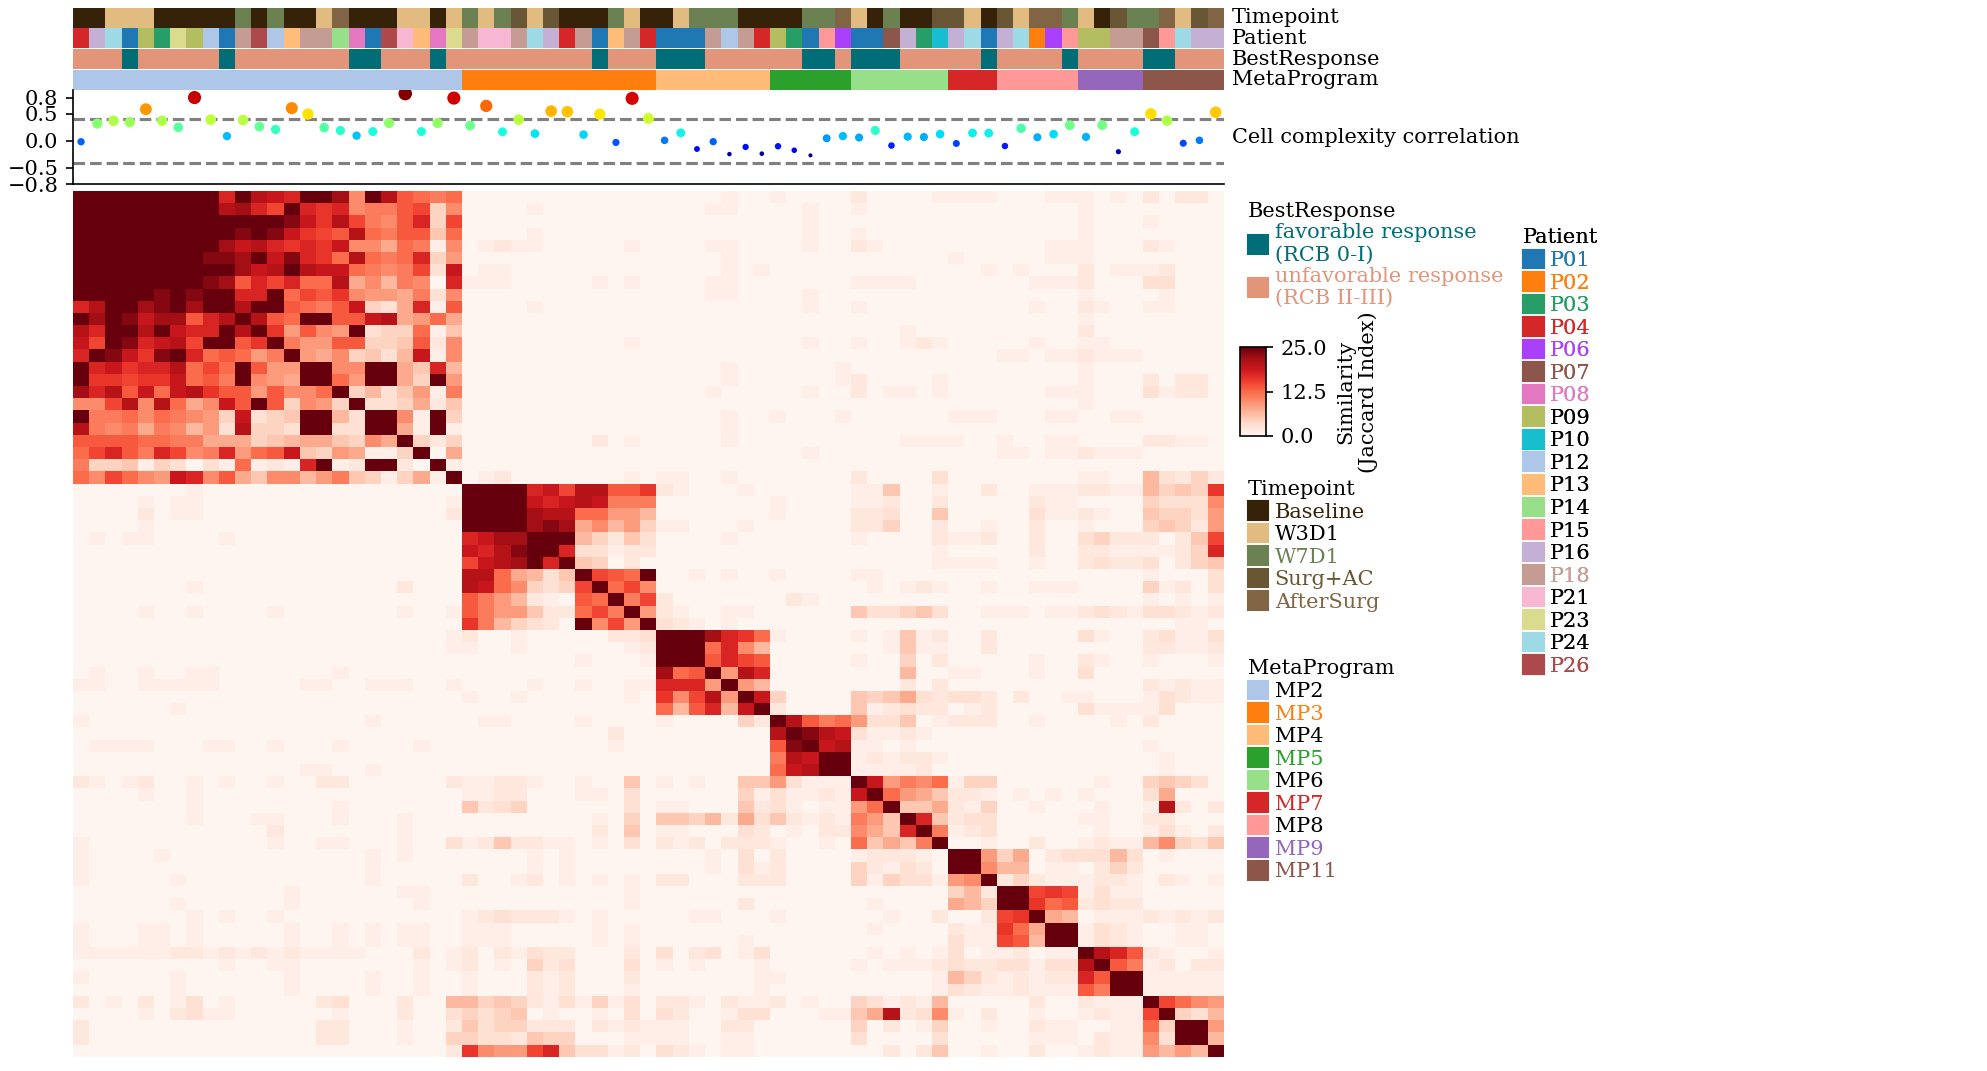

In [18]:
from PyComplexHeatmap import \
ClusterMapPlotter,HeatmapAnnotation,anno_simple,anno_label,DotClustermapPlotter,anno_scatterplot
## Get the order the program
anno['Cell_complexity_cor'] = nmf_corr_complexity
order = New_Programs_Order

## column annotation
n_mp = Cluster_Map.nunique()
COLOR_PAlETTE['MetaProgram'] = MP_colors
col_dict={}
for col in ['Timepoint','Patient','BestResponse','MetaProgram']:#'Treatment_Arm',
    colors = { k:v for k,v in COLOR_PAlETTE[col].items() if k in anno[col].unique()}
    col_dict[col] = anno_simple(anno[col],
                              legend_kws=dict(frameon=False),
                              colors=colors)
    
col_dict['Cell complexity correlation']= anno_scatterplot(
    anno['Cell_complexity_cor'],height=14,legend=False,grid=False
)

col_ha = HeatmapAnnotation(**col_dict,verbose=0,axis=1)
row_ha = HeatmapAnnotation(
    MetaProgram = anno_simple(anno['MetaProgram'],legend=False),verbose=0,axis=0
)
## plot
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(10, 8),dpi=150)


cm = ClusterMapPlotter(data=sm.loc[order,order],
                       top_annotation=col_ha,
                       row_cluster=False,col_cluster=False,
#                        left_annotation=row_ha,
#                        col_split=rph_anno['RPH'],row_split=rph_anno['RPH'],
#                        row_split_gap=0.8,col_split_gap=0.8,
                       vmin=0,
                       vmax=25,
                       label='Similarity\n(Jaccard Index)', row_dendrogram=False,legend_gap=7,
                       cmap='Reds',rasterized=True)

## Change the ylim for the correlation plot
cutoff=.4
ax=col_ha.annotations[4].ax
ax.set_yticks([-0.8,-0.5,0,0.5,0.8]);
ax.axhline(y=cutoff,ls='--',color='gray')
ax.axhline(y=-cutoff,ls='--',color='gray')

## Visualize the gene expression in each MP

In [18]:
def make_index_unique(index: pd.Index, join: str = "-"):
    if index.is_unique:
        return index
    from collections import Counter

    values = index.values.copy()
    indices_dup = index.duplicated(keep="first")
    values_dup = values[indices_dup]
    values_set = set(values)
    counter = Counter()
    issue_interpretation_warning = False
    example_colliding_values = []
    for i, v in enumerate(values_dup):
        while True:
            counter[v] += 1
            tentative_new_name = v + join + str(counter[v])
            if tentative_new_name not in values_set:
                values_set.add(tentative_new_name)
                values_dup[i] = tentative_new_name
                break
            issue_interpretation_warning = True
            if len(example_colliding_values) < 5:
                example_colliding_values.append(tentative_new_name)

    if issue_interpretation_warning:
        warnings.warn(
            f"Suffix used ({join}[0-9]+) to deduplicate index values may make index "
            + "values difficult to interpret. There values with a similar suffixes in "
            + "the index. Consider using a different delimiter by passing "
            + "`join={delimiter}`"
            + "Example key collisions generated by the make_index_unique algorithm: "
            + str(example_colliding_values)
        )
    values[indices_dup] = values_dup
    index = pd.Index(values, name=index.name)
    return index

In [19]:
# ---------------------------------------------------------------------------------------------
# Function for getting a control geneset
# --------------------------------------------------------------------------------------------- 

# - ave_tpm = named vector with the average tpm/cpm expression of genes in the expression matrix
# - program = a character vector of genes in the program 
# - bins = number of bins used to divide ranked genes
# - size = control gene set size scaling factor (e.g. 100x the size of the original program)

# Returns a characther vector with the control gene set 

def control_geneset(ave_tpm, program, bins=50, size=100):
    import random
    # define n bins of gene expression
    expr_bins = pd.cut(ave_tpm,bins)
    # for each program gene, selects 100 control genes from the correspondent bin 
    control_geneset  = {}
    for c in program:
        test = program[c].tolist()
        bin_w_test = expr_bins[test].values
        ctrl_in_bin = expr_bins[expr_bins.isin(bin_w_test)].index.tolist()
        control_geneset[c] = random.choices(ctrl_in_bin,k=size)
    return control_geneset

## MP presentation by sample

In [20]:
anno.groupby(['Sample'])['MetaProgram'].unique()

Sample
CCG1112_01_T1_A              [MP4, MP2, MP3, MP6, MP7]
CCG1112_01_T2_A                        [MP2, MP4, MP6]
CCG1112_01_T3_A                             [MP4, MP5]
CCG1112_02_T2_A                                  [MP8]
CCG1112_03_T1_A1_SN_5GEX               [MP2, MP5, MP6]
CCG1112_04_T1_A                        [MP2, MP3, MP4]
CCG1112_06_T4_A                             [MP8, MP5]
CCG1112_07_T3_A                            [MP11, MP6]
CCG1112_08_T1_A1_SN_5GEX                         [MP2]
CCG1112_09_T1_A                        [MP2, MP5, MP9]
CCG1112_09_T2_A                             [MP2, MP9]
CCG1112_10_T4_A                                  [MP6]
CCG1112_12_T1_A                                  [MP2]
CCG1112_12_T3_A                             [MP2, MP4]
CCG1112_13_T1_A1_SN_5GEX                         [MP2]
CCG1112_13_T2_A1_SN_5GEX                         [MP2]
CCG1112_13_T3_A1_SN_5GEX                         [MP3]
CCG1112_14_T2_A                                  [MP2]
CCG

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 12.172222222222222 mm


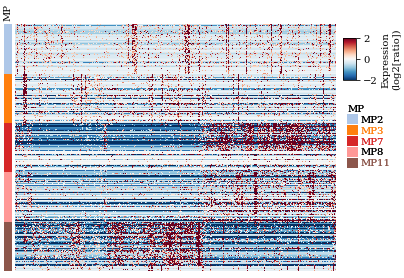

In [21]:
sample_id = 'CCG1112d_24_T1_A' 
geneset_belongs= anno.groupby(['Sample'])['MetaProgram'].unique()
genes = np.ravel(MP_Genesets.loc[:,MP_Genesets.columns!='MP_Unknown'].values)
# genes = MP_Genesets['MP11'].tolist()
# ctrl_genes = adata.var_names[~adata.var_names.isin(genes)]
barcodes = adata.obs.index[adata.obs['Sample']==sample_id]
data = pd.DataFrame(adata[barcodes,genes].X.toarray(),index=barcodes,columns=genes).T
# tpm = pd.DataFrame(adata[barcodes,:].X.toarray(),index=barcodes,columns=adata.var_names).T
# ctrl_geneset = control_geneset(tpm.mean(axis=1),MP_Genesets)

data.index = make_index_unique(data.index)
# center the data
data = (data.T - data.mean(axis=1)).T
# data = data / data.std()



df_rows = pd.concat([pd.Series(c,index=MP_Genesets[c],name='MP')
                     for c in MP_Genesets if  c in geneset_belongs[sample_id]]).to_frame()
df_rows.index = make_index_unique(df_rows.index)

colors = { k:v for k,v in COLOR_PAlETTE['MetaProgram'].items() if k in df_rows['MP'].unique()}

row_ha = HeatmapAnnotation(
                           MP=anno_simple(df_rows['MP'],legend=True,
                                          legend_kws=dict(frameon=False),
                                          colors=colors),
                           verbose=0,axis=0,plot_legend=True)

# order the cells
# ave_df = []
# for mp,gset in df_rows.groupby('MP'):
#     mp_ave = data.loc[gset.index,:].mean()
#     mp_ave.name = mp
#     ave_df.append(mp_ave)
# ave_df = pd.concat(ave_df,axis=1)

# order = ave_df.sort_values(by=ave_df.columns.tolist(),ascending=False).index

cm = ClusterMapPlotter(data=data.loc[df_rows.index,:],
                       left_annotation=row_ha,
                       col_cluster=True,
                       col_cluster_method='complete',
                       row_cluster=False,
                       vmax=2,
                       center = 0,
                       vmin=-2,
                       label='Expression\n(log2[ratio])',legend_gap=7,
                       cmap='RdBu_r',rasterized=True)


## Write out the Genesets for every MP

In [22]:
mp_gmt_path = f'{Manuscript_RESULT}/MPs/Tumor/MP_Programs.gmt'
with open(mp_gmt_path,'w') as f:
    for mp in New_MP_Genesets:
        f.write('\t'.join([mp,'MetaProgram_HRpos']+MP_Genesets[mp].tolist())+'\n')

## Define the Geneset for each program

# Annotation of reccurent program

## Gavish et al. 2023 - Hallmarks of transcriptional intratumour heterogeneity across a thousand tumours

In [19]:
ref_ITH = pd.read_excel(f'{EXTERNAL_DATA}/meta_programs_2023-07-13.xlsx',sheet_name='Malignant')
ref_ITH = ref_ITH.loc[:,ref_ITH.columns!='Unassigned']

### Similarity of individual RHP with reference ITH

In [20]:
n_top = min(ref_ITH.shape[0],robustRPH.shape[0])
rph_ref_sm = robustRPH.apply(
        lambda c1:
           ref_ITH.apply(
            lambda c2: jaccard_index(c1,c2) * 100
            ,axis=0)
        ,axis=0)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 78.67083333333333 mm
Incresing ncol


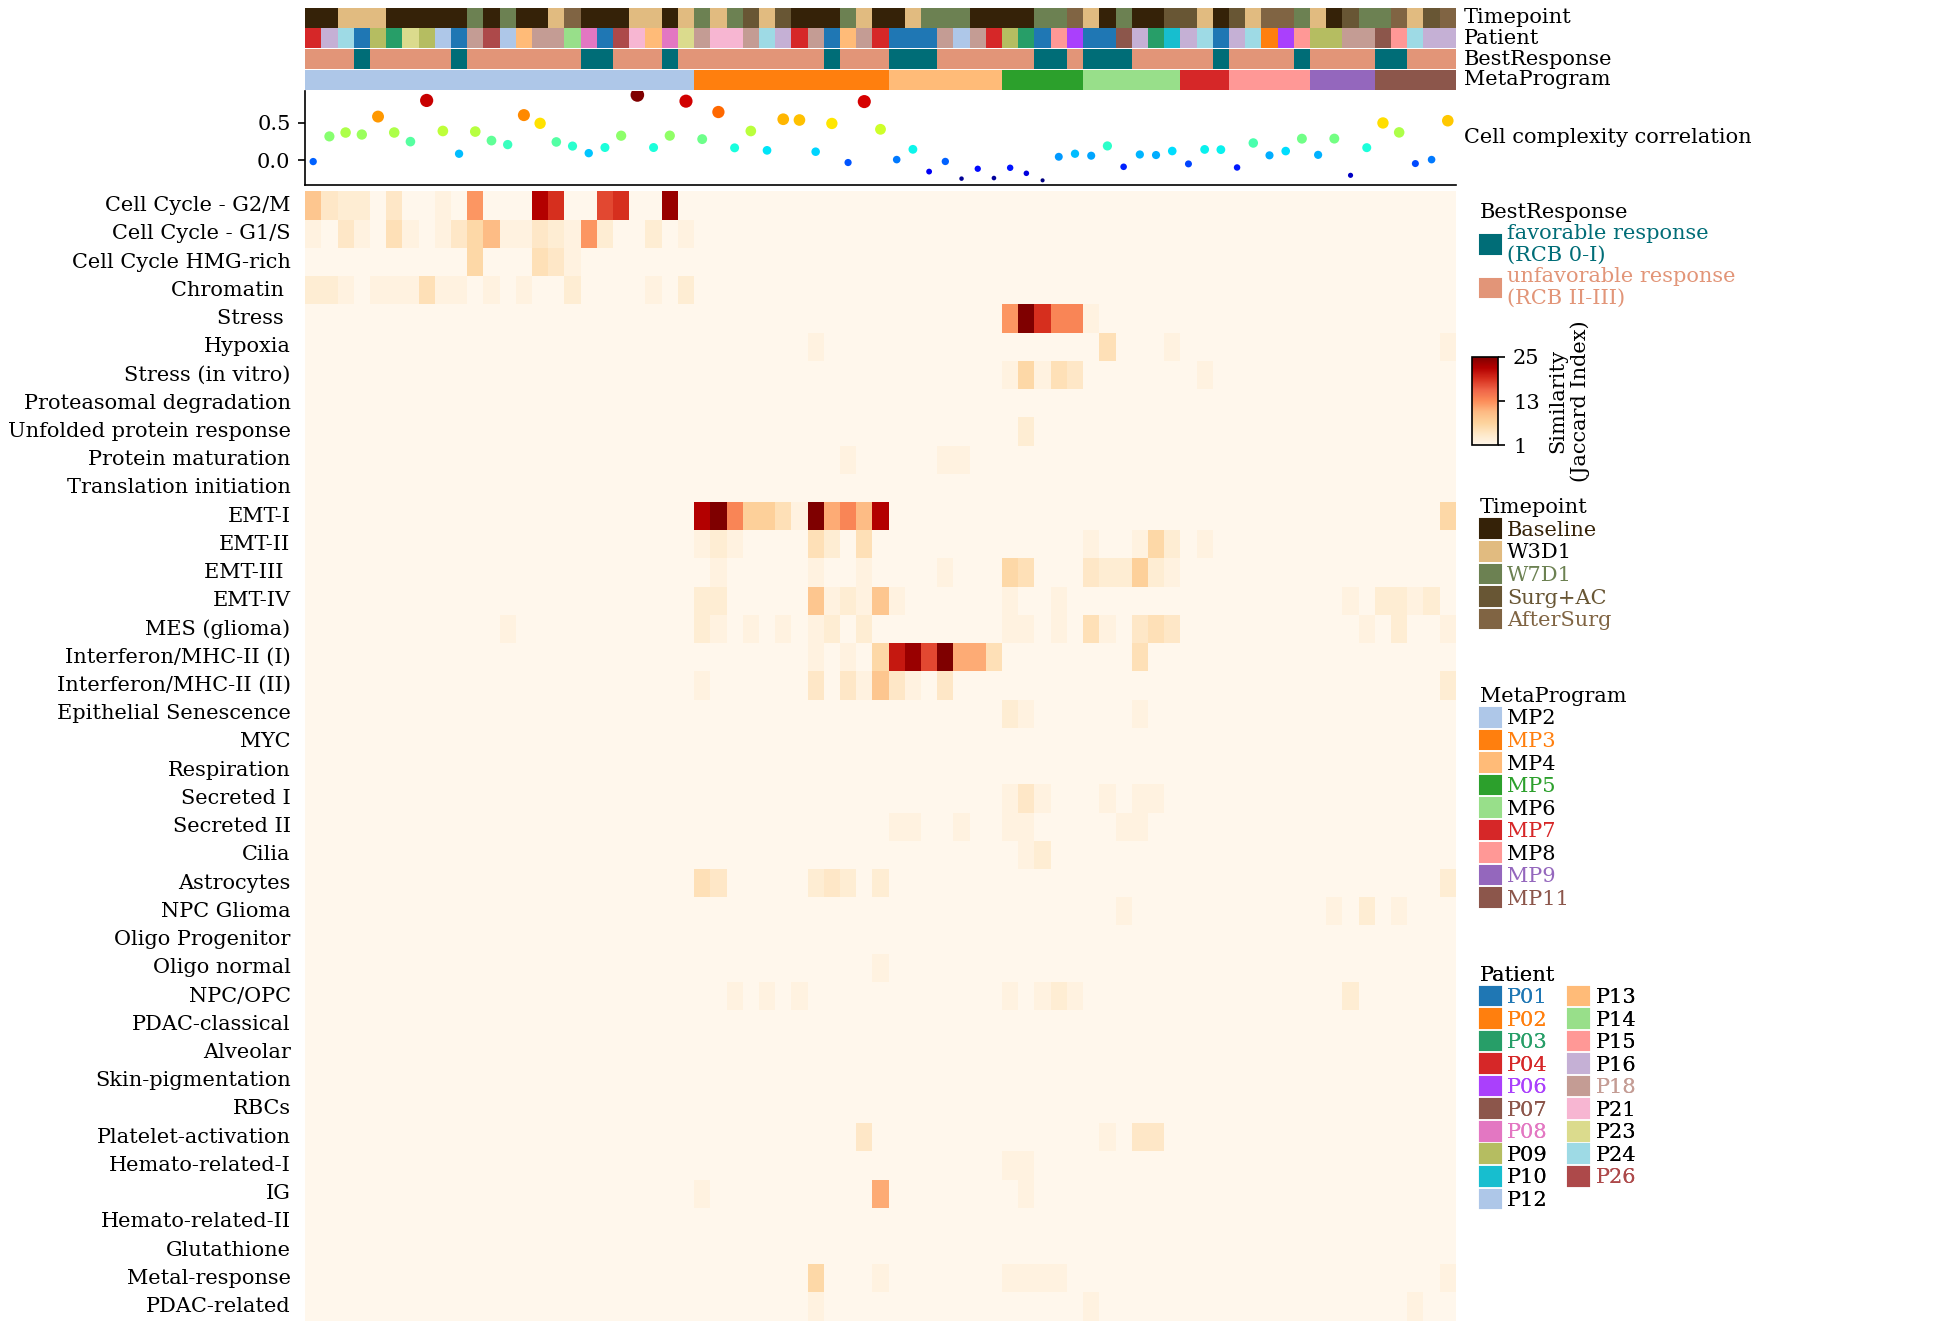

In [21]:
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(10, 10),dpi=150)
cm = ClusterMapPlotter(data=rph_ref_sm.loc[:,order],
                       top_annotation=col_ha,
                       left_annotation=None,
                       show_rownames=True,
                       row_names_side='left',
                       row_cluster=False,col_cluster=False,
                       vmin=1,
                       vmax=25,
                       label='Similarity\n(Jaccard Index)', row_dendrogram=False,legend_gap=7,
                       cmap='OrRd',rasterized=True)

### Similarity of metaRHP with reference ITH

In [26]:
New_MP_Genesets.apply(
        lambda c1:
           ref_ITH.apply(
            lambda c2: len(set(c1).intersection(set(c2)))
            ,axis=0)
        ,axis=0).idxmax().to_dict()

{'MP4': 'Interferon/MHC-II (I)',
 'MP2': 'Cell Cycle - G2/M',
 'MP3': 'EMT-I',
 'MP6': 'EMT-III ',
 'MP7': 'Stress (in vitro)',
 'MP5': 'Stress ',
 'MP8': 'Secreted II',
 'MP11': 'EMT-IV',
 'MP9': 'NPC Glioma'}

In [27]:
(New_MP_Genesets.apply(
        lambda c1:
           ref_ITH.apply(
            lambda c2: len(set(c1).intersection(set(c2)))
            ,axis=0)
        ,axis=0).max().sort_values() > 5)

MP7     False
MP8     False
MP9     False
MP11    False
MP6     False
MP2      True
MP3      True
MP4      True
MP5      True
dtype: bool

<Axes: >

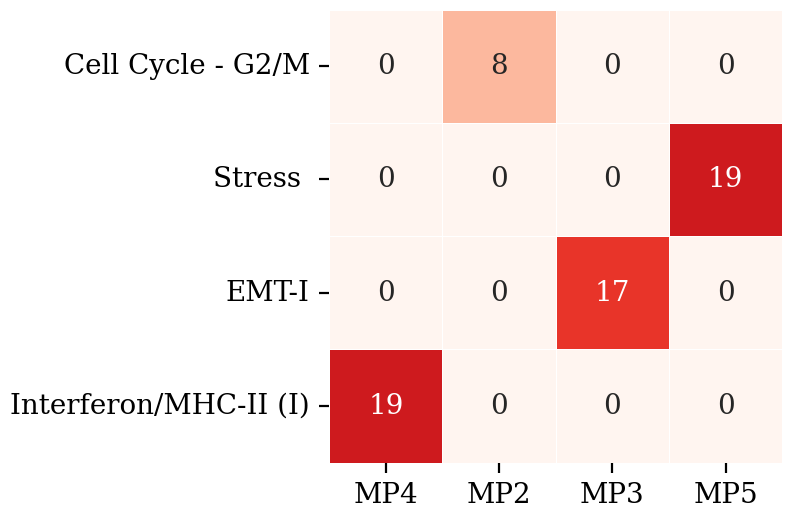

In [28]:
meta_ref_sm = New_MP_Genesets.apply(
        lambda c1:
           ref_ITH.apply(
            lambda c2: len(set(c1).intersection(set(c2)))
            ,axis=0)
        ,axis=0)
meta_ref_sm = meta_ref_sm.loc[((meta_ref_sm >= 7).sum(axis=1)>=1),((meta_ref_sm >= 7).sum(axis=0)>=1)]
fig,ax=plt.subplots(1,1,figsize=(3,3),dpi=200)
sns.heatmap(meta_ref_sm,lw=.2,
              cmap='Reds',vmin=2,vmax=25,square=True,cbar_kws={'label':'Intersection'},ax=ax,
           annot=True,cbar=False)

## Hallmark and GO term bp/cc Geneset Enricher 

In [29]:
import gseapy as gp
MP_pathway = {}
for program in New_MP_Genesets:
    genelist = New_MP_Genesets[program].tolist()
    get = True
    while get:
        try:
            enr = gp.enrichr(gene_list=genelist,
                     gene_sets=[f"{EXTERNAL_DATA}/KEGG_2021_Human.gmt",
                                f"{EXTERNAL_DATA}/h.all.v2023.1.Hs.symbols.gmt",
                                f"{EXTERNAL_DATA}/c5.go.bp.v2023.1.Hs.symbols.gmt",
                               f"{EXTERNAL_DATA}/c5.go.cc.v2023.1.Hs.symbols.gmt",
                               f"{EXTERNAL_DATA}/c5.go.mf.v2023.1.Hs.symbols.gmt"],
                     organism='human',
                     background=bg_genes.tolist(),
                     outdir=None, # don't write to disk
                            )
            get = False
        except Exception as e:
            if e!='Error sending gene list, try again later':
                print(e)
    res = enr.results
#     res = res.loc[res['Adjusted P-value']<0.05,:]
    MP_pathway[program] = res


top_n = 10
enr_res = {}
with pd.ExcelWriter(f'{Manuscript_RESULT}/MPs/Tumor/ITH_Enricher.xlsx') as file:
    for name,temp in MP_pathway.items():
        top_geneset = []
        for geneset,df in temp.groupby('Gene_set'):
            top_geneset.append(
                df.sort_values(['Adjusted P-value'],
                                ascending=True).head(top_n)
            )
        result = pd.concat(top_geneset,axis=0)
        result.to_excel(file, sheet_name = name, index=False)
        enr_res[name] = result
del temp,result

In [30]:
enr_res = pd.read_excel(f'{Manuscript_RESULT}/MPs/Tumor/ITH_Enricher.xlsx', sheet_name=None)

In [31]:
enr_res['MP9']

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human.gmt,Apelin signaling pathway,4/102,4.918102e-04,0.022698,13.466350,102.578812,ITPR2;GNGT1;PLAT;AGTR1
1,KEGG_2021_Human.gmt,Long-term depression,3/44,5.278683e-04,0.022698,24.437413,184.420939,ITPR2;PRKG1;GRIA2
2,KEGG_2021_Human.gmt,Serotonergic synapse,3/60,1.309722e-03,0.037545,17.616934,116.940149,KCND2;GNGT1;ITPR2
3,KEGG_2021_Human.gmt,Circadian entrainment,3/67,1.801307e-03,0.038728,15.697022,99.193292,GNGT1;PRKG1;GRIA2
4,KEGG_2021_Human.gmt,Glutamatergic synapse,3/74,2.394732e-03,0.041189,14.153036,85.406274,ITPR2;GNGT1;GRIA2
5,KEGG_2021_Human.gmt,Vascular smooth muscle contraction,3/80,2.989502e-03,0.042850,13.051613,75.864437,ITPR2;PRKG1;AGTR1
6,KEGG_2021_Human.gmt,Retrograde endocannabinoid signaling,3/99,5.440113e-03,0.058481,10.467358,54.576336,ITPR2;GNGT1;GRIA2
7,KEGG_2021_Human.gmt,Dopaminergic synapse,3/96,4.993217e-03,0.058481,10.805573,57.266023,ITPR2;GNGT1;GRIA2
8,KEGG_2021_Human.gmt,cGMP-PKG signaling pathway,3/109,7.100276e-03,0.067847,9.477588,46.891521,ITPR2;PRKG1;AGTR1
9,KEGG_2021_Human.gmt,Renin secretion,2/43,1.048936e-02,0.082008,17.095392,77.910433,ITPR2;AGTR1


## Manual annotation

we recorded evidences for the program annotaion in the suppl slides.

In [32]:
New_MP_Genesets.columns.map(lambda x:int(x.replace('MP',''))).sort_values()

Int64Index([2, 3, 4, 5, 6, 7, 8, 9, 11], dtype='int64')

In [33]:
for c in New_MP_Genesets:
    if 'MAP1B' in New_MP_Genesets[c].tolist():
        print(c)

MP9


## Final MP annotation

In [34]:
MP_anno_map = {
    'MP2':'Cell_Cycle',
    'MP3':'EMT-I',
    'MP4':'Interferon/MHCII(I)',
    'MP5':'Stress',
    'MP6':'EMT-II',
    'MP7':'ER-I',
    'MP8':'ER-II',
    'MP9':'Apelin',
    'MP11':'EMT-III'
}

## Assign the annotation to MPs column

In [35]:
anno['MPs'] = anno.MetaProgram.map(MP_anno_map)
anno['MPs'].value_counts().sort_index()

Apelin                  4
Cell_Cycle             24
EMT-I                  12
EMT-II                  6
EMT-III                 5
ER-I                    3
ER-II                   5
Interferon/MHCII(I)     7
Stress                  5
Name: MPs, dtype: int64

## Representative gene set  selection

In [36]:
MP_Visual_Genes = {
    'MP2':["BRCA1","TOP2A","TPX2"],
    'MP3':["VIM","FN1","VCAN"],
    'MP4':['STAT1','TAP1','CXCL10'],
    'MP5':['CCN1','TIPARP','CCNL1'],
    'MP6':['TNFRSF12A','FLNA','PMEPA1'],
    'MP7':['GATA3','FUT8','RHOBTB3'],
    'MP8':['AR','PAPSS2','DHRS2'],
    'MP9':['GNGT1','MAP1B','NEGR1'],
    'MP11':['DST','PAM','XDH']
}

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


Text(0.5, 0.98, 'Metaprogram related function')

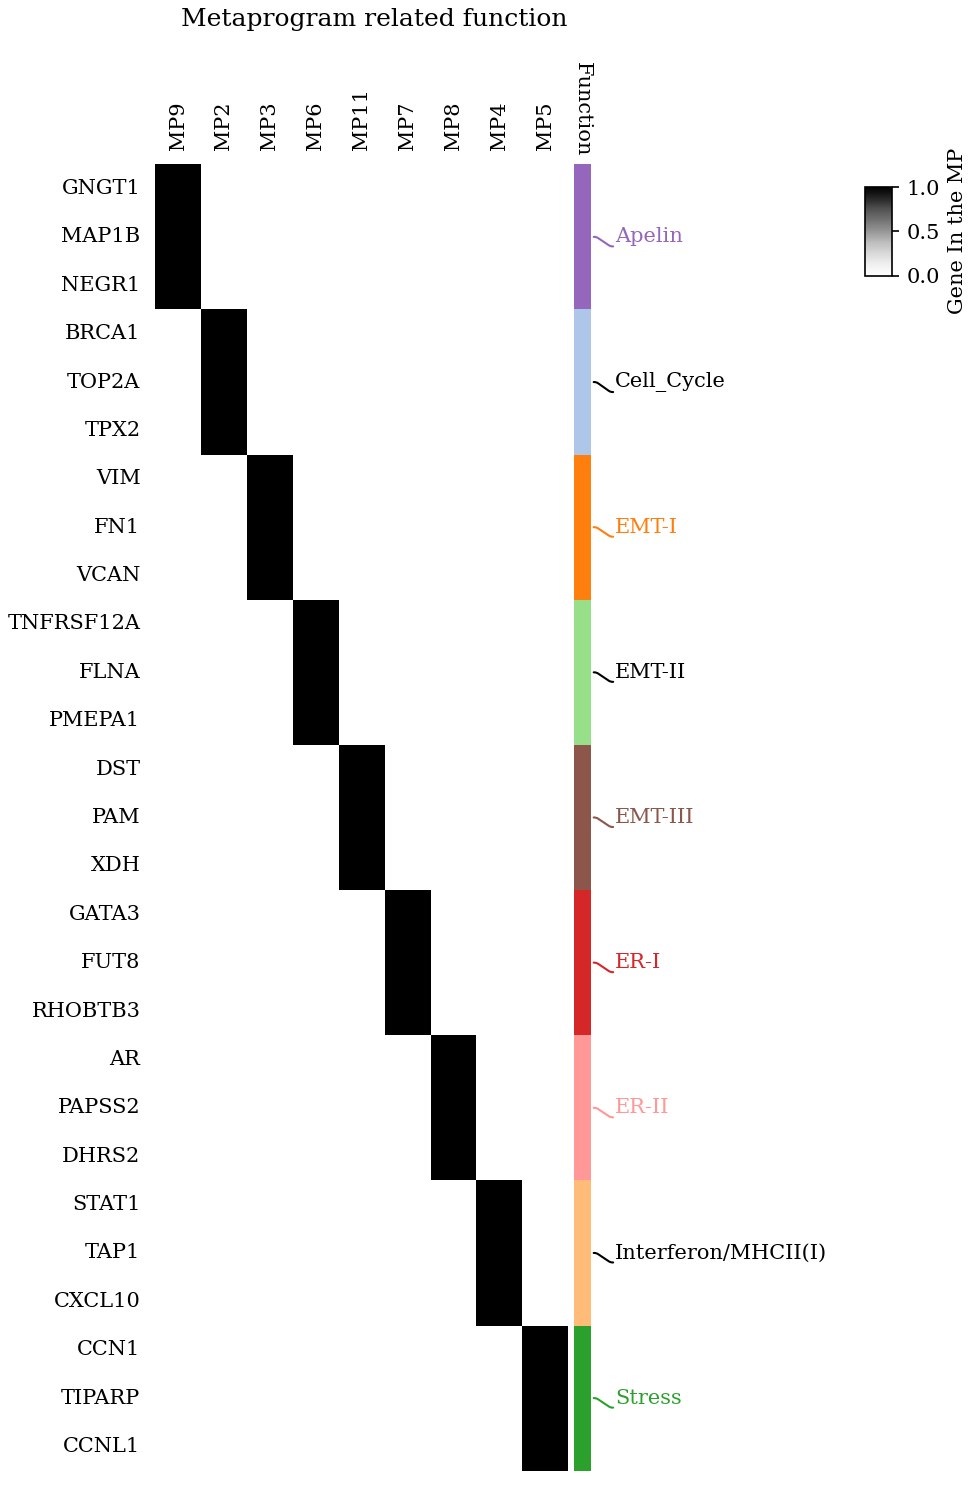

In [37]:
genes = pd.Series(np.vstack(MP_Visual_Genes.values()).flatten())
genes.index=genes
dt = New_MP_Genesets.apply(lambda c: genes.map(lambda x: x in c.values),axis=0).astype(int)
dt = dt.sort_values(dt.columns.tolist())

df_rows = pd.DataFrame(MP_Visual_Genes).unstack().reset_index().set_index(0)
colors = { MP_anno_map[k]:v for k,v in COLOR_PAlETTE['MetaProgram'].items() if k in df_rows['level_0'].unique()}
df_rows['MP'] = df_rows['level_0'].map(MP_anno_map)
df_rows = df_rows.sort_values('MP')
col_orders = df_rows['level_0'].unique().tolist()
dt = dt[col_orders].sort_values(col_orders,ascending=False)
df_rows = df_rows.loc[dt.index,:]

row_ha = HeatmapAnnotation(
    Function=anno_simple(df_rows['MP'],legend=False,
                           legend_kws=dict(frameon=False),
                           colors=colors),
     Anno=anno_label(df_rows['MP'],legend=False,
                          colors=colors,merge=True),
    verbose=0,axis=0,plot_legend=True)


plt.figure(figsize=(4, 10),dpi=150)
cm = ClusterMapPlotter(data=dt,
                       right_annotation=row_ha,
                       col_cluster=False,
                       row_cluster=False,
                       show_colnames=True,
                       show_rownames=True,
                       vmax=1,
                       vmin=0,
                       label='Gene In the MP',
                       cmap='Greys',rasterized=True,col_names_side='top')
plt.suptitle('Metaprogram related function')

## Store annotation

In [38]:
mp_anno_path = f'{Manuscript_RESULT}/MPs/Tumor/MetaProgram_Annotation.csv'
anno.to_csv(mp_anno_path,index=True)

# Cellstate annotation

In [39]:
scores_path = f'{WORKFLOW_DATA}/{GEX_Cohort}/HR_BRCA_MetaProgram.csv'
ref_ITH=pd.read_table(mp_gmt_path,header=None,index_col=0).drop([1],axis=1).T
ref_anno = pd.read_csv(mp_anno_path)
MP_anno_map = ref_anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
# get MP sores on all cells 
scores = pd.read_csv(scores_path,index_col=0)
# select the signature scoring method
signature_method ='VISION'
scores = scores[scores.columns[scores.columns.str.endswith(signature_method)]]
scores.columns = scores.columns.map(lambda x:x.split('_')[0]).map(MP_anno_map)
scores

,Interferon/MHCII(I),Cell_Cycle,EMT-I,EMT-II,ER-I,Stress,ER-II,EMT-III,Apelin
CTCTAGCTCCGTGACA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,1.090037,0.949820,2.145981,3.018099,0.794341,1.037353,0.408186,3.653724,1.000169
AGCGATTTCTATTGTC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,1.060983,0.626584,1.515372,2.763045,0.393587,1.150732,0.385483,4.298751,1.010139
GTGCACGGTATACTGG-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,1.073133,0.663292,1.910368,2.951624,0.444976,0.661144,0.780612,5.705826,1.217294
TCCACAACACATGCTA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,0.857328,1.072945,2.037957,2.306717,1.710290,0.618504,0.975268,4.251299,1.039251
ATGAATGCATCCGTAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,0.494133,0.697514,0.470433,1.887798,4.242550,0.613716,2.363956,0.894916,1.613358
...,...,...,...,...,...,...,...,...,...
CATCGAATCGACAGCC-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,-0.008954,-0.139214,0.121305,0.157290,0.889248,-0.008954,1.236874,0.605775,0.382585
ACTGCTCTCATTCACT-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,0.165385,-0.137984,0.232815,0.263333,0.934408,-0.004212,0.964501,-0.004212,0.336198
GAACATCGTAAGAGGA-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,0.230335,0.194561,0.335789,0.356510,0.467864,0.921693,0.412868,2.141814,0.427240
CATCAAGGTCTGGAGA-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,-0.122859,0.028272,-0.122859,0.028272,0.217461,0.028272,0.771196,0.269311,0.888727


In [45]:
from signaturescoring.scoring_methods.gmm_postprocessing import GMMPostprocessor
import anndata
tumor = anndata.AnnData(obs=scores)
# initialize GMMPostprocessor
gmm_post = GMMPostprocessor(
    n_components=scores.shape[1]
)
# fit the GMM model on the 3 columns of the scores
features_name = scores.columns.tolist()
store_name_pred, store_names_proba, _ = gmm_post.fit_and_predict(tumor,features_name )

# assign clusters to signatures
assignments = gmm_post.assign_clusters_to_signatures(tumor,features_name, store_names_proba, plot=False)
scoring_names_gmm = []
for key, val in assignments.items():
    if key =='rest':
        continue
    tumor.obs[key+'_gmm'] = tumor.obs[val].copy()
    scoring_names_gmm.append(key+'_gmm')

In [89]:
pd.Series(assignments).iloc[:-1].sort_values()

ER-II                  1_GMM_proba
Interferon/MHCII(I)    4_GMM_proba
EMT-I                  4_GMM_proba
Cell_Cycle             5_GMM_proba
ER-I                   6_GMM_proba
Apelin                 6_GMM_proba
EMT-III                7_GMM_proba
EMT-II                 8_GMM_proba
Stress                 8_GMM_proba
dtype: object

### Explore the correlation between MPs

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 30.516666666666666 mm


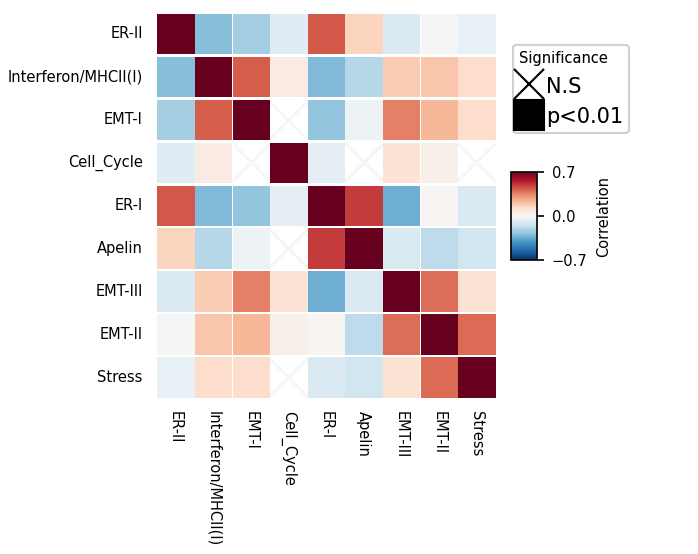

In [93]:
dt =  scores.copy()
order = pd.Series(assignments).iloc[:-1].sort_values().index.tolist()
pvalues = []
for c in dt:
    p = dt.apply(lambda a: scipy.stats.pearsonr(a.values,dt[c].values)[1])
    p.name= c
    pvalues.append(p)
pvalues = pd.concat(pvalues,axis=1)
corr =  dt.corr()

data = corr.unstack().rename('Correlation').to_frame()
data['pvalue'] = pvalues.unstack()
data['Significance'] = 'N.S'
data.loc[data['pvalue']<0.01,'Significance'] = 'p<0.01'

data = data.reset_index()#.drop_duplicates(['pvalue','Correlation'])
# data = data.loc[data.level_0!=data.level_1,:]

plt.figure(figsize=(3, 3),dpi=150)


# col_ha = HeatmapAnnotation(label=anno_label(pd.Series(['Endocytosis','Lipid','Presentation','Interferon','Adhesion','Secretion'])))
cm = DotClustermapPlotter(data=data, x='level_0',y='level_1',value='Correlation',c='Correlation',hue='Significance',
                          s=4,
                          col_split=pd.Series(order,index=order),
                          col_split_order = order,
                          row_split=pd.Series(order,index=order),
                          row_split_order = order,
                          marker={'N.S':'x','p<0.01':'s'},
                          vmax=.7,vmin=-.7,cmap='RdBu_r',
                          ratio=200,
                          row_cluster=False,col_cluster=False,
                          show_rownames=True,show_colnames=True,row_names_side='left')
plt.show()

In [62]:
curr_val= tumor.obs[scoring_names_gmm].idxmax(axis="columns")
cellstate= curr_val.map(lambda x:'Tumor.'+x.replace('_gmm','')).rename('Cellstate').to_frame()
cellstate.to_csv(f'{Manuscript_RESULT}/MPs/Tumor/Annotation.csv')

In [63]:
obs_path = f'{REPO}/data/result/manuscript_table/GEX_OBS.csv'
obs = pd.read_csv(obs_path,index_col=0)
# cross sanity check
for c in ['Cellstate','BestResponse','Patient','Timepoint','Sample_Short','Treatment_Arm','RCB']:
    adata.obs[c] = obs.loc[adata.obs.index,c]
pd.crosstab(adata.obs.loc[cellstate.index,'Cellstate'],cellstate['Cellstate'])

Cellstate,Tumor.Cell_Cycle,Tumor.EMT-II,Tumor.EMT-III,Tumor.ER-I,Tumor.ER-II,Tumor.Interferon/MHCII(I)
Cellstate,,,,,,
Tumor.Cell_Cycle,13885,0,0,0,0,0
Tumor.EMT-II,0,5441,0,0,0,0
Tumor.EMT-III,0,0,2704,0,0,0
Tumor.ER-I,0,0,0,30197,0,0
Tumor.ER-II,0,0,0,0,9833,0
Tumor.Interferon/MHCII(I),0,0,0,0,0,3146


In [52]:
adata.obs['Cellstate']= cellstate['Cellstate']

## MP marker visualization

In [64]:
sp.utils.log1pNorm(adata)

In [65]:
ref_ITH=pd.read_table(mp_gmt_path,header=None,index_col=0).drop([1],axis=1).T
anno = pd.read_csv(mp_anno_path,index_col=0)
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
ref_ITH.columns = ref_ITH.columns.map(MP_anno_map)
ref_ITH=ref_ITH.melt()
ref_ITH.columns = ['Program','gene']
ref_ITH = ref_ITH.drop_duplicates(subset=['gene'],keep=False).set_index('gene')

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 30.516666666666666 mm


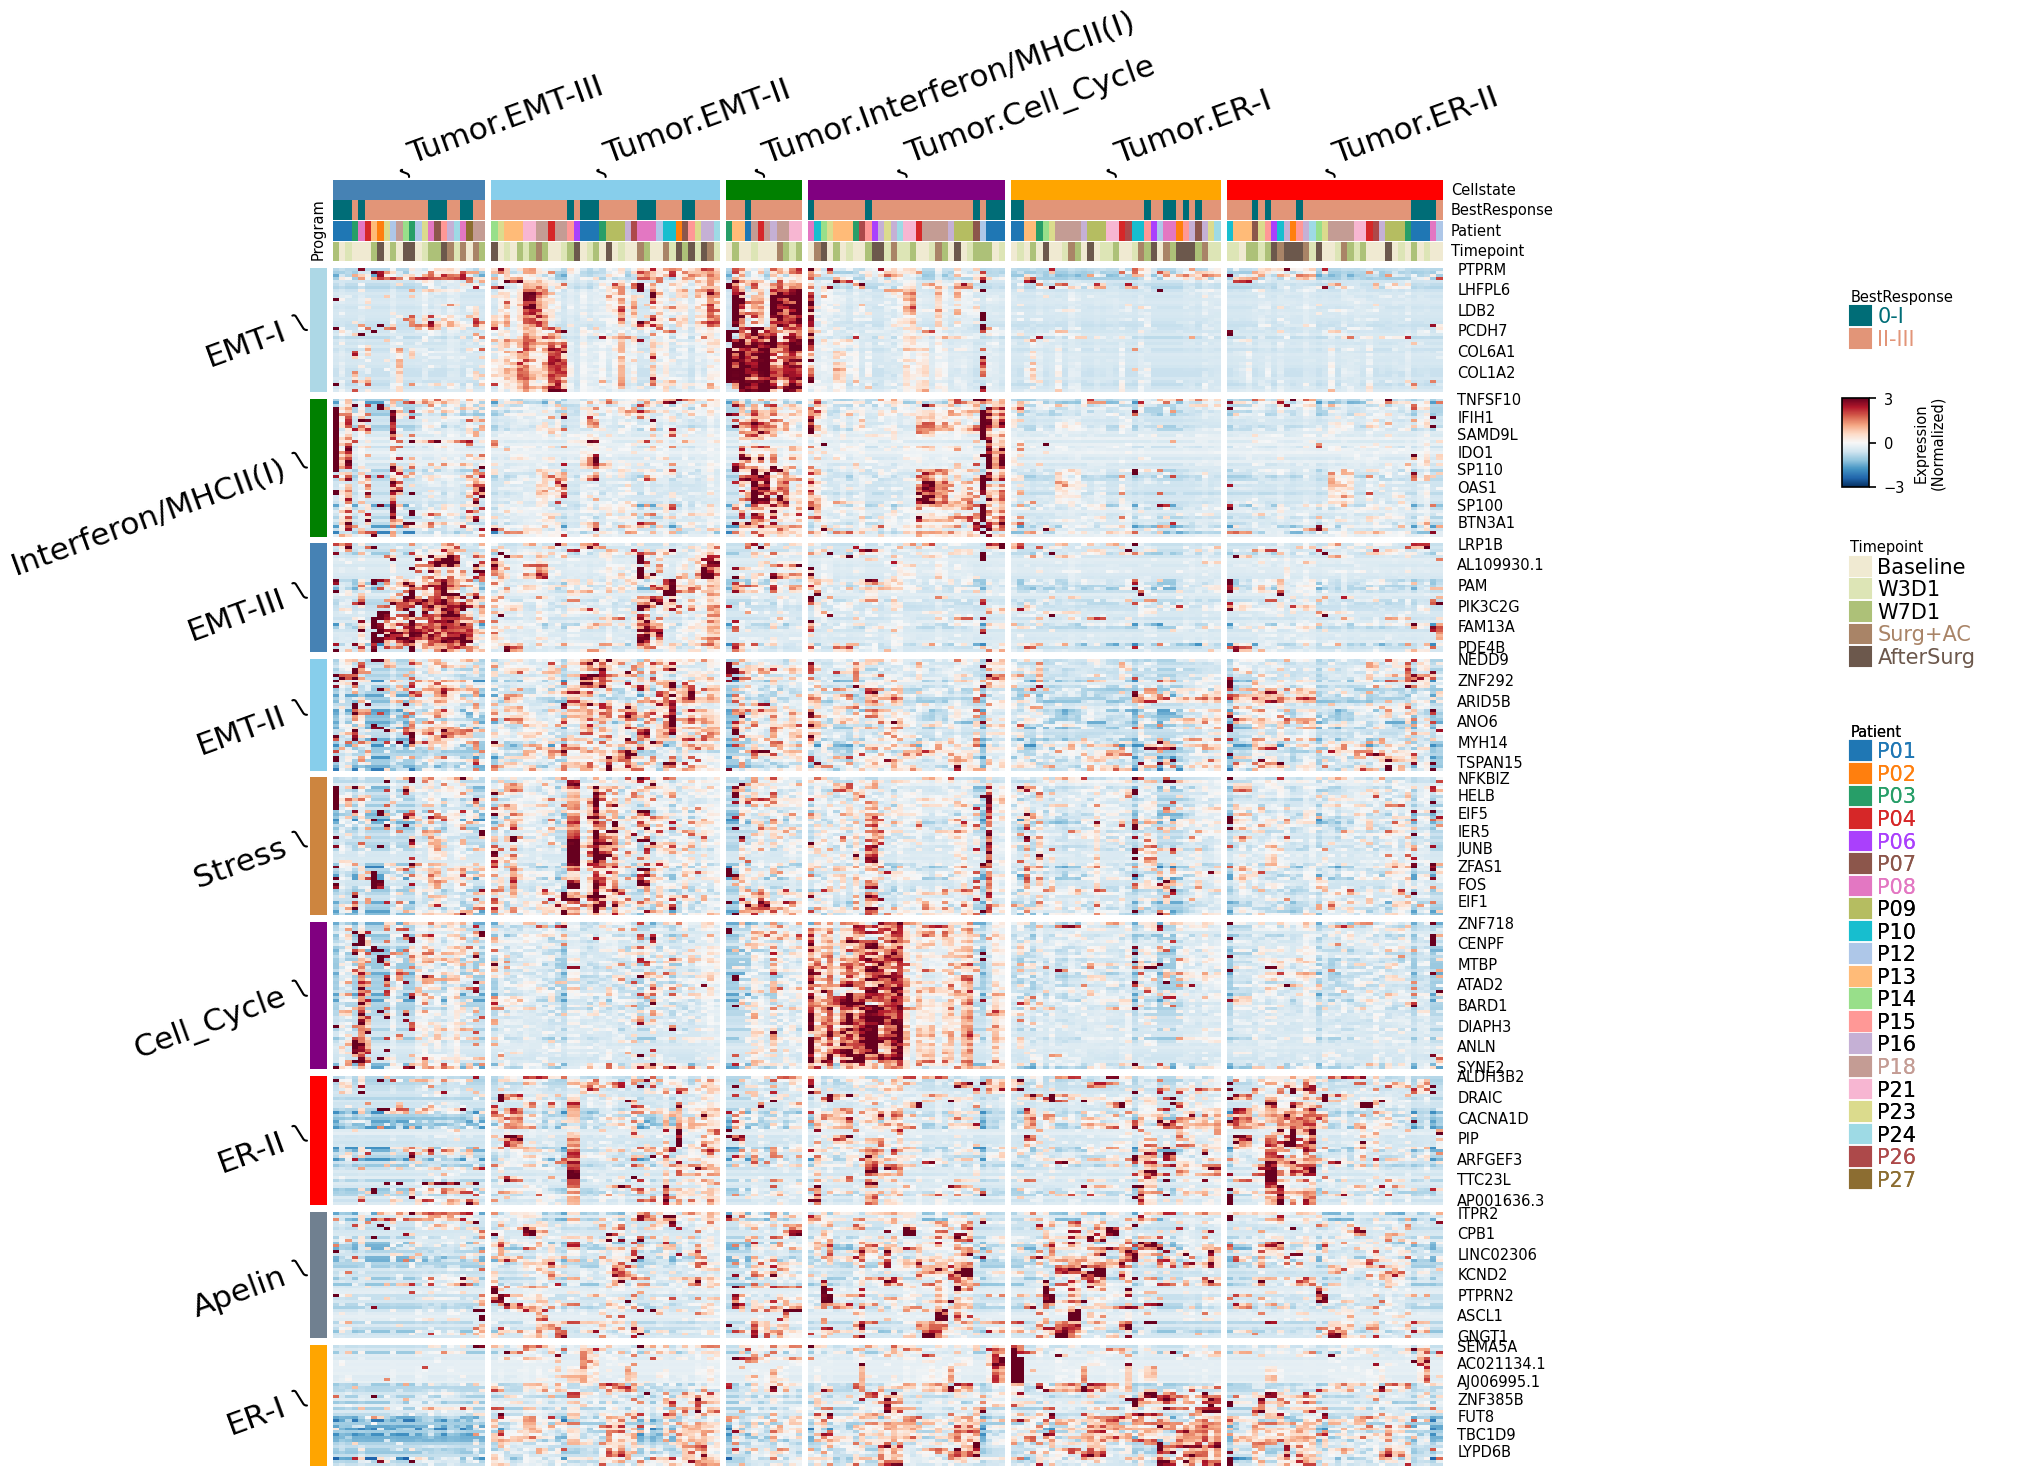

In [69]:
palette={}
palette['Program'] = {k.replace('Tumor.',''):v for k,v in COLOR_PAlETTE['Cellstate'].items() if 'Tumor' in k}
for c in ['BestResponse','Patient','Timepoint','Cellstate']:
    palette[c] = COLOR_PAlETTE[c]
aggregate_heatmap(adata=adata,
                  features=ref_ITH,
                  top_anno_columns=['Cellstate','BestResponse','Patient','Timepoint'],
                  col_split='Cellstate',
                  col_split_gap=1,
                  row_split='Program',
                  row_split_gap=1,
                  palette=palette,
                  figsize=(10,10),
                  vmin=-3,
                  vmax=3,
                  standard_normalization=True,
                  cbar_label='Expression\n(Normalized)',
                  cmap='RdBu_r'
                 )